In [1]:
import ee
import numpy as np
import matplotlib.pyplot as plt

ee.Initialize()
sentinel1 = ee.ImageCollection('COPERNICUS/S1_GRD')

In [2]:
# Define date range
start_date = ee.Date('2018-01-01')
end_date = start_date.advance(180, 'day')    # 180 days later
sentinel1 = sentinel1.filterDate(start_date, end_date)

# Grab the VH and VV polarized parts in interferometric
# wide swath mode
vh = sentinel1.filter(
    ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')).filter(
    ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')).filter(
    ee.Filter.eq('instrumentMode', 'IW'))

# Separate data collected when the sat was ascending and descending
ascending = vh.filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'));
descending = vh.filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'));

# Create a composite from means at different polarizations
# and look angles *for visualization*
composite = ee.Image.cat([
    ascending.select('VH').max(),
    descending.select('VH').max(), 
    ee.ImageCollection(ascending.select('VV').merge(
        descending.select('VV'))).max()]).focal_median();

# Construct box to generate data for
llx = 50.34
lly = 24.82
urx = 51.96
ury = 26.25

# centroid = [51.336665, 25.111551]
# WIDTH = 2
# HEIGHT = 2
# llx = centroid[0] - WIDTH / 2
# lly = centroid[1] - HEIGHT / 2
# urx = centroid[0] + WIDTH / 2
# ury = centroid[1] + HEIGHT / 2

area = ee.Geometry.Polygon([[llx,lly], [llx,ury], [urx,ury], [urx,lly]])

In [3]:
# Grab the region of interest
latlon = ee.Image.pixelLonLat().addBands(composite)
latlon = latlon.reduceRegion(
  reducer=ee.Reducer.toList(),
  geometry=area,
#   maxPixels=1e8,
  scale=200);

# Grab each polarization (and latlon data) from the composite
vh = np.array((ee.Array(latlon.get("VH")).getInfo()))
vv = np.array((ee.Array(latlon.get("VV")).getInfo()))
lats = np.array((ee.Array(latlon.get("latitude")).getInfo()))
lons = np.array((ee.Array(latlon.get("longitude")).getInfo()))

In [18]:
## Get size stuff for plotting

# get the unique coordinates
uniqueLats = np.unique(lats)
uniqueLons = np.unique(lons)

# get number of columns and rows from coordinates
ncols = len(uniqueLons)    
nrows = len(uniqueLats)
 
# determine pixelsizes
ys = uniqueLats[1] - uniqueLats[0] 
xs = uniqueLons[1] - uniqueLons[0]

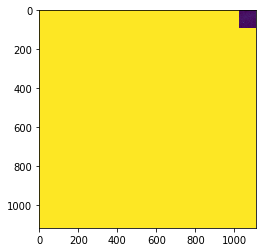

In [19]:
## Plot VH polarized data

# create an array with dimensions of image
vh_arr = np.zeros([nrows, ncols], np.float32) #-9999
 
# fill the array with values
counter = 0
for y in range(0,len(vh_arr),1):
    for x in range(0,len(vh_arr[0]),1):
        if lats[counter] == uniqueLats[y] and lons[counter] == uniqueLons[x] and counter < len(lats)-1:
            counter += 1
            vh_arr[len(uniqueLats)-1-y,x] = vh[counter] # we start from lower left corner

# Plot VH
plt.imshow(vh_arr)
plt.show()

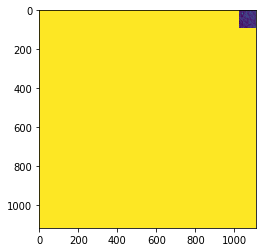

In [6]:
## Plot VV polarized data

# create an array with dimensions of image
vv_arr = np.zeros([nrows, ncols], np.float32) #-9999
 
# fill the array with values
counter =0
for y in range(0,len(vv_arr),1):
    for x in range(0,len(vv_arr[0]),1):
        if lats[counter] == uniqueLats[y] and lons[counter] == uniqueLons[x] and counter < len(lats)-1:
            counter+=1
            vv_arr[len(uniqueLats)-1-y,x] = vv[counter] # we start from lower left corner

# Plot VV
plt.imshow(vv_arr)
plt.show()

In [7]:
# Save to file
vh_arr.tofile('vh.out')
vv_arr.tofile('vv.out')

In [9]:
vh_arr.shape

(1116, 1113)

In [15]:
nrows

1116

In [16]:
ncols

1113

In [17]:
reshaped = vh.reshape((nrows, ncols))

ValueError: cannot reshape array of size 1238989 into shape (1116,1113)

In [22]:
imvh = composite.get('VH')

In [25]:
imvh)

array(<ee.computedobject.ComputedObject object at 0x7f932df20b38>,
      dtype=object)

In [26]:
latlon = ee.Image.pixelLonLat().addBands(composite)

In [30]:
llvhinfo = latlon.get('VH').getInfo()

In [32]:
type(llvhinfo)

NoneType

In [7]:
geometry = [[llx,lly], [llx,ury], [urx,ury], [urx,lly]]

task_config = {
#     'description': 'vhExport',
    'scale': 200,  
    'region': geometry
    }

task = ee.batch.Export.image(composite, 'vhExport', task_config)

task.start()